# 2-D Lattice Test #

In this example, we run the VBMDS-GP with the 2-D Lattice as a test

In [1]:
using Winston
using Distances
using Distributions
using Optim

In [2]:
# create dataset
# generate simple grid
nX = 10^2
X = zeros(nX,2)
k = 1
for i = 1:sqrt(nX), j = 1:sqrt(nX)
    X[k,:] = 1.0*[i, j]
    k = k+1
end

Mdist = pairwise(Euclidean(), X').^2
k=1

nreps = 5
#nD = round(Int,((nX^2) - nX)/2)*nreps
nD = (nX^2 - nX)*nreps
println(nD)
D = zeros(nD, 3)
vn_true = 0.1
for reps = 1:nreps
    for i = 1:nX, j = 1:nX
        if i!=j
            d = LogNormal(log(Mdist[i,j]), sqrt(vn_true))
            D[k,:] = [i, j, rand(d) ]
            k = k+1
        end
    end
end


49500


In [3]:
D

49500×3 Array{Float64,2}:
   1.0   2.0   1.1757  
   1.0   3.0   4.73847 
   1.0   4.0  10.2236  
   1.0   5.0  18.2488  
   1.0   6.0  22.1826  
   1.0   7.0  50.316   
   1.0   8.0  54.7312  
   1.0   9.0  96.6206  
   1.0  10.0  68.479   
   1.0  11.0   1.03722 
   1.0  12.0   2.56025 
   1.0  13.0   4.29288 
   1.0  14.0   9.50178 
   ⋮                   
 100.0  88.0   4.00616 
 100.0  89.0   3.33853 
 100.0  90.0   0.747791
 100.0  91.0  58.448   
 100.0  92.0  90.9754  
 100.0  93.0  36.4421  
 100.0  94.0  39.3338  
 100.0  95.0  22.2911  
 100.0  96.0  13.1919  
 100.0  97.0   6.29673 
 100.0  98.0   3.59699 
 100.0  99.0   0.852446

In [4]:
X # this are the true underlying positions. 

100×2 Array{Float64,2}:
  1.0   1.0
  1.0   2.0
  1.0   3.0
  1.0   4.0
  1.0   5.0
  1.0   6.0
  1.0   7.0
  1.0   8.0
  1.0   9.0
  1.0  10.0
  2.0   1.0
  2.0   2.0
  2.0   3.0
  ⋮        
  9.0   9.0
  9.0  10.0
 10.0   1.0
 10.0   2.0
 10.0   3.0
 10.0   4.0
 10.0   5.0
 10.0   6.0
 10.0   7.0
 10.0   8.0
 10.0   9.0
 10.0  10.0

In [5]:
function getFeatures(X; Nirr=0)
    feat = [1.0./X[:,1].^2-X[:,2] X[:,1]./X[:,2] X[:,1]+X[:,2]]
    feat = hcat(feat, 10*rand(size(X,1), Nirr))
end

getFeatures (generic function with 1 method)

In [6]:
Nirr = 0
Xtest = getFeatures(X, Nirr=Nirr)

100×3 Array{Float64,2}:
  0.0       1.0        2.0
 -1.0       0.5        3.0
 -2.0       0.333333   4.0
 -3.0       0.25       5.0
 -4.0       0.2        6.0
 -5.0       0.166667   7.0
 -6.0       0.142857   8.0
 -7.0       0.125      9.0
 -8.0       0.111111  10.0
 -9.0       0.1       11.0
 -0.75      2.0        3.0
 -1.75      1.0        4.0
 -2.75      0.666667   5.0
  ⋮                       
 -8.98765   1.0       18.0
 -9.98765   0.9       19.0
 -0.99     10.0       11.0
 -1.99      5.0       12.0
 -2.99      3.33333   13.0
 -3.99      2.5       14.0
 -4.99      2.0       15.0
 -5.99      1.66667   16.0
 -6.99      1.42857   17.0
 -7.99      1.25      18.0
 -8.99      1.11111   19.0
 -9.99      1.0       20.0

In [7]:
# side information
# nonlinear transformation of the input coordinates
#Xtest = [2*X[:,1].^2-X[:,2] X[:,1].*X[:,2] X[:,1]+X[:,2]]

#for i=1:size(Xtest,2)
#    Xtest[:,i] = (Xtest[:,i] - mean(Xtest[:,i]))./(1.0+maximum(Xtest[:,i]))
#end
Xfeat = Xtest

# We set the inducing input locations with some noise
Xu = Xtest # inducing input locations
Xu = Xu + 0.05*rand(size(Xu))
println("Num Inducing inputs: ",size(Xu,1))

Num Inducing inputs: 100


In [8]:
Xfeat

100×3 Array{Float64,2}:
  0.0       1.0        2.0
 -1.0       0.5        3.0
 -2.0       0.333333   4.0
 -3.0       0.25       5.0
 -4.0       0.2        6.0
 -5.0       0.166667   7.0
 -6.0       0.142857   8.0
 -7.0       0.125      9.0
 -8.0       0.111111  10.0
 -9.0       0.1       11.0
 -0.75      2.0        3.0
 -1.75      1.0        4.0
 -2.75      0.666667   5.0
  ⋮                       
 -8.98765   1.0       18.0
 -9.98765   0.9       19.0
 -0.99     10.0       11.0
 -1.99      5.0       12.0
 -2.99      3.33333   13.0
 -3.99      2.5       14.0
 -4.99      2.0       15.0
 -5.99      1.66667   16.0
 -6.99      1.42857   17.0
 -7.99      1.25      18.0
 -8.99      1.11111   19.0
 -9.99      1.0       20.0

In [9]:
include("vbmds.jl") # load in the VBMDS code


vbmds

In [10]:
# set up parameters
srand(0)

nZ = nX # number of latent points
num_lower_dim = 32 # number of latent dimensions

lbfunc = vbmds.lognormalEucMixLB #likelihood lower bound
#lbfunc = vbmds.normalSqEucLB

kfunc = vbmds.seNNkernel
slb = 1.0
hyp = rand(size(Xfeat,2).^2)
hyp = vcat(hyp, [slb])

#kfunc = vbmds.seARDkernel # kernel function
#hyp = rand(size(Xfeat,2))# hyperparameters

#kfunc = vbmds.sekernel # kernel function
#hyp = [2.0]# hyperparameters

#vcat(hyp, [0.02])
#kfunc = vbmds.sekernel
#hyp=[0.02]
m = [] # mean of inducing variables (set to [] if you want auto init)
v = [] # diagonal of inducing variables (set to [] if you want auto init)
mu = []
s2 = [] #10.0*ones(nZ, num_lower_dim)
vn = vn_true #noise variance
m0 = [] # initial prior for m (Set to [] if you want auto)
v0 = [] # intiial prior for v (Set to [] if you want auto)
mu0 = []
s20 = [] #.1*ones(nZ, num_lower_dim)
init_method = "random"# "random" for random initialization, "mds" for MDS initialization
mds_vn = 0.01

params = vbmds.VBMDSMixParams(Xu, num_lower_dim, 
lbfunc, kfunc, 
hyp, 
m, v, 
mu, s2,
vn, 
m0, v0,
mu0, s20,
init_method, mds_vn)
println("Parameters Set up!")

Parameters Set up!


In [11]:
nnhyplb = -10*ones(length(params.hyp))#sqrt(0.01),
nnhypub = 10*ones(length(params.hyp))#sqrt(100.0)
nnhyplb[end] = slb 
nnhypub[end] = slb + 100

101.0

In [12]:
Xfeat[2:2,:]

1×3 Array{Float64,2}:
 -1.0  0.5  3.0

In [13]:
Xfeat_local = Xfeat[1:end-2,:]
#Xfeat_local = []
nXfeat = size(Xfeat_local,1)

nZ = nX
params = vbmds.VBMDSMix(D, Xfeat_local, nZ, params; 
opt_method=LBFGS(),
sample_size = 300, #run on all 
num_iterations= 10, 
opt_iterations = 10,
opt_hyp_iterations = 10,
opt_vn_iterations = 10,
local_iterations= 1, 
report_interval=100, 
fixed_noise = false,
fixed_hyp = false,
show_trace = true,
vlb = 1.0e-2,
vub = 1.0,
s2lb = 1.0e-4,
s2ub = 10.0,
vnlb = 1.0e-5,
vnub = 2*vn_true,
hyplb = nnhyplb,#sqrt(0.01),
hypub = nnhypub#sqrt(100.0)
)

println("Done Optimizing.")
#run(`say -v Allison \"Done Optimizing Lattice \"`)


Creating Parameters
Setting up Fixed Variables
Outer Iteration: 1
Local Sample Iteration: 1
Iter     Function value   Gradient norm 
     0     4.511947e+03     3.951974e+00
     1     3.150782e+03     2.374513e+00
     2     2.905483e+03     2.094613e+00
     3     2.676727e+03     2.555165e+00
     4     2.485230e+03     2.256386e+00
     5     2.381765e+03     1.423375e+00
     6     2.336474e+03     1.436819e+00
     7     2.306740e+03     6.535768e-01
     8     2.284819e+03     7.435374e-01
     9     2.265733e+03     7.392042e-01
    10     2.237044e+03     5.008416e-01
Number Function Calls: 38
Number Gradient Calls: 38
Iter     Function value   Gradient norm 
     0     3.606584e+05     1.443397e+06


LoadError: InterruptException:

In [986]:
params.vn
println(params.m)
println(params.s2)
println(params.s2)

Float64[]
Float64[]
Float64[]


Using GP


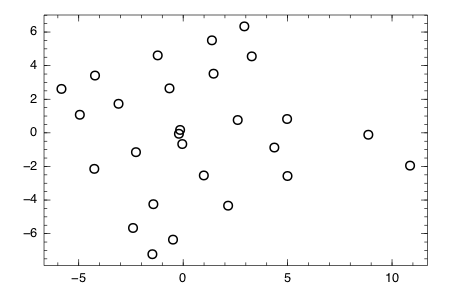

In [970]:
# Prediction
p = 0

#plotting via Winston
hold(false)
if Xfeat_local != []
    (mZ_pred, vZ_pred) = vbmds.VBMDSMix(0, Xfeat, nZ, params)
    vZ_pred = abs(vZ_pred)
    println("Using GP")
    errbarsx = SymmetricErrorBarsX(mZ_pred[:,1], mZ_pred[:,2], 2*sqrt(vZ_pred[:,1]))
    errbarsy = SymmetricErrorBarsY(mZ_pred[:,1], mZ_pred[:,2], 2*sqrt(vZ_pred[:,2]))

    p = scatter(mZ_pred[:,1], mZ_pred[:,2])
    hold(true)
    #add(p, errbarsx)
    #add(p, errbarsy)
end

if nZ > nXfeat
    p = scatter(params.mu[:,1], params.mu[:,2])

    hold(true)
    errbarsx_z = SymmetricErrorBarsX(params.mu[:,1], params.mu[:,2], sqrt(params.s2[:,1]))
    errbarsy_z = SymmetricErrorBarsY(params.mu[:,1], params.mu[:,2], sqrt(params.s2[:,2]))
    #add(p, errbarsx_z)
    #add(p, errbarsy_z)
end
p

In [971]:
Xoos = [3.1 3.1;
        1.5 1.5;
        1.5 2.5
        ]
Xfeat_oos = getFeatures(Xoos, Nirr=Nirr)

3×3 Array{Float64,2}:
 -2.99594  1.0  6.2
 -1.05556  1.0  3.0
 -2.05556  0.6  4.0

Using GP


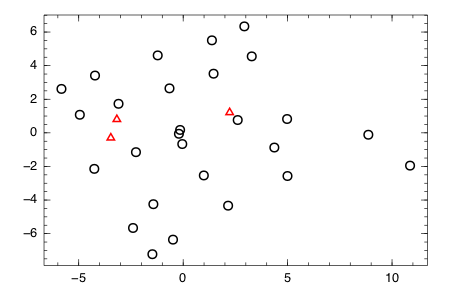

In [972]:
# prediction with out-of-sample points 
#plotting via Winston
hold(true)
if Xfeat_local != []
    (mZ_pred, vZ_pred) = vbmds.VBMDSMix(0, Xfeat_oos, nZ, params)
    println("Using GP")
    errbarsx = SymmetricErrorBarsX(mZ_pred[:,1], mZ_pred[:,2], 2*sqrt(vZ_pred[:,1]))
    errbarsy = SymmetricErrorBarsY(mZ_pred[:,1], mZ_pred[:,2], 2*sqrt(vZ_pred[:,2]))

    p = plot(mZ_pred[:,1], mZ_pred[:,2], "r^")
    hold(true)
    #add(p, errbarsx)
    #add(p, errbarsy)
end
p

In [962]:
mZ_pred

3×2 Array{Float64,2}:
  -1.68519  -1.25839
  -9.72664  26.9059 
 -13.0734   18.6087 

In [173]:

a = [1,2,3,4]
a = reshape(a, length())

2×2 Array{Int64,2}:
 1  3
 2  4

In [258]:
a = [[]; [1,2,3]]
Array{Float64}(a)

3-element Array{Float64,1}:
 1.0
 2.0
 3.0